<a href="https://colab.research.google.com/github/khavitidala/kMeans-from-scratch-with-kNNImputer-and-PCA/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasterisasi Data Pelanggan Kendaraan Bermotor pada Suatu Dealer

by Ryan Abdurohman (1301191171) kelas IF-43-10

### Deskripsi Permasalahan

Tugas clustering (unsupervised Learning) adalah mengelompokkan pelanggan berdasarkan data pelanggan di dealer tanpa memperhatikan label kelas apakah pelanggan tertarik untuk membeli kendaraan baru atau tidak. 

SIM	--> 0 : Tidak punya SIM 1 : Punya SIM<br>
Kode_Daerah --> Kode area tempat tinggal pelanggan<br>
Sudah_Asuransi --> 1 : Pelanggan sudah memiliki asuransi kendaraan, 0 : Pelanggan belum memiliki asuransi kendaraan<br>
Umur_Kendaraan --> Umur kendaraan<br>
Kendaraan_Rusak --> 1 : Kendaraan pernah rusak sebelumnya. 0 : Kendaraan belum pernah rusak.<br>
Premi --> Jumlah premi yang harus dibayarkan per tahun.<br>
Kanal_Penjualan --> Kode kanal untuk menghubungi pelanggan (email, telpon, dll)<br>
Lama_Berlangganan	--> Sudah berapa lama pelanggan menjadi klien perusahaan<br>
Tertarik --> 1 : Pelanggan tertarik, 0 : Pelanggan tidak tertarik
<br>

### Import Library

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid


In [ ]:
# Set seed untuk mendapatkan reproducible result
def set_seed(s):
  os.environ['PYTHONHASHSEED']=str(s)
  random.seed(s)
  np.random.seed(s)

### Downloading Datasets

In [ ]:
!gdown --id 1b-JCp_edWr7zvK-_Awk-mjq-siDnbySx

Downloading...
From: https://drive.google.com/uc?id=1b-JCp_edWr7zvK-_Awk-mjq-siDnbySx
To: /content/kendaraan_train.csv
100% 15.2M/15.2M [00:00<00:00, 48.5MB/s]


In [ ]:
df = pd.read_csv("kendaraan_train.csv")

## Exploratory Data Analysis

### Melihat Cuplikan Data

In [ ]:
df.head()

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0


### Melihat Informasi pada Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285831 entries, 0 to 285830
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 285831 non-null  int64  
 1   Jenis_Kelamin      271391 non-null  object 
 2   Umur               271617 non-null  float64
 3   SIM                271427 non-null  float64
 4   Kode_Daerah        271525 non-null  float64
 5   Sudah_Asuransi     271602 non-null  float64
 6   Umur_Kendaraan     271556 non-null  object 
 7   Kendaraan_Rusak    271643 non-null  object 
 8   Premi              271262 non-null  float64
 9   Kanal_Penjualan    271532 non-null  float64
 10  Lama_Berlangganan  271839 non-null  float64
 11  Tertarik           285831 non-null  int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 26.2+ MB


### Deteksi Missing Value

#### Menggunakan missingno library untuk melihat persebaran data yang hilang (missing value)
Hal ini penting, karena visualisasi ini dapat memberikan kita insight, apakah persebaran missing value itu terpusat atau tersebar di kolom/baris pada data. Kita bisa lihat bahwa data missing value pada dataset tersebar, sehingga diperlukan beberapa strategi untuk mengatasi ini

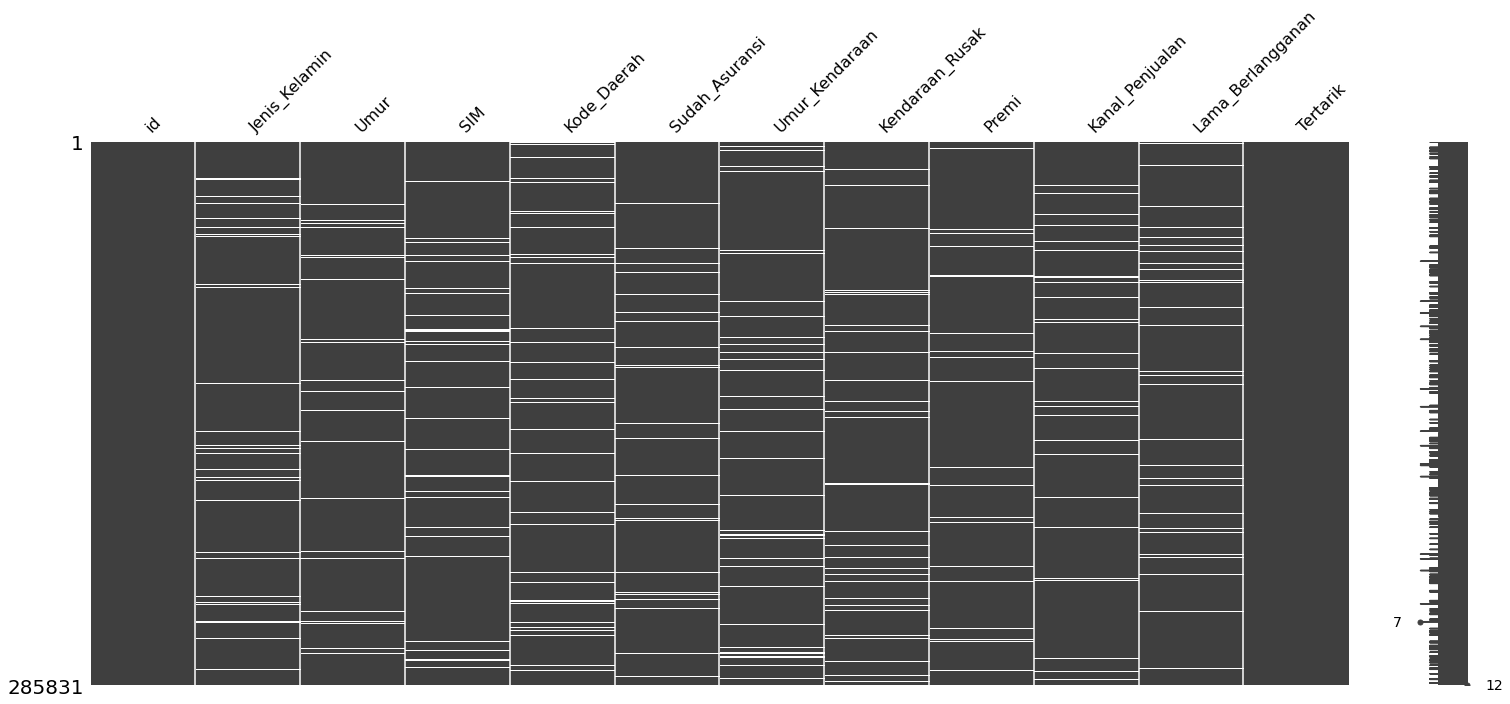

In [ ]:
msno.matrix(df)

Melihat secara presisi berapa ukuran dari dataset

In [ ]:
df.shape

(285831, 12)

Data yang kita dapat cukup banyak, lalu kita lihat seberapa banyak missing value pada setiap kolomnya

In [ ]:
df.isna().sum()

id                       0
Jenis_Kelamin        14440
Umur                 14214
SIM                  14404
Kode_Daerah          14306
Sudah_Asuransi       14229
Umur_Kendaraan       14275
Kendaraan_Rusak      14188
Premi                14569
Kanal_Penjualan      14299
Lama_Berlangganan    13992
Tertarik                 0
dtype: int64

Ternyata kolom yang hilang cukup banyak. Maka, diputuskan bahwa kita harus menerapkan beberapa strategi untuk mengatasi ini. Eksperimen yang dapat dilakukan berupa:
1. Drop baris yang didalamnya terdapat missing value
2. Mengisi missing value dengan rata-rata dari data setiap kolom
3. Menggunakan teknik imputation


## Preprocessing

### Drop Data pada Kolom Label dan Data yang Memiliki sedikit Kategori

Hal ini disebabkan kita akan menggunakan k-Means clustering yang pada dasarnya menggunakan jarak. Data kategori yang dihapus adalah data yang kategorinya sedikit.

Misal, ada data jenis kelamin yang hanya ada dua kategori laki-laki dan perempuan (0 dan 1). Nah, ketika data nanti dinormalisasi dengan rentang 0-1, maka data jenis kelamin ini akan mengganggu penghitungan jarak dengan fitur yang lain.

Sedangkan data label didrop karena memang kita tidak menggunakan label pada proses clustering.

In [ ]:
df.nunique()

id                   285831
Jenis_Kelamin             2
Umur                     66
SIM                       2
Kode_Daerah              53
Sudah_Asuransi            2
Umur_Kendaraan            3
Kendaraan_Rusak           2
Premi                 45114
Kanal_Penjualan         151
Lama_Berlangganan       290
Tertarik                  2
dtype: int64

Kita bisa melihat data id itu sebagai primary key sehingga data ini tidak memiliki pengaruh pada dataset secara keseluruhan. Namun, id tidak akan didrop pada saat ini karena id bisa digunakan untuk membantu memudahkan indeks klasterisasi. Lalu, kita bisa lihat juga ada beberapa kolom yang memiliki sedikit kategori, maka kita bisa drop kolom-kolom tersebut.

In [ ]:
numdf = df.drop(['Jenis_Kelamin', 'SIM', 'Sudah_Asuransi', 'Umur_Kendaraan', 'Kendaraan_Rusak', 'Tertarik'], axis=1)

In [ ]:
numdf.head()

,id,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan
0,1,30.0,33.0,28029.0,152.0,97.0
1,2,48.0,39.0,25800.0,29.0,158.0
2,3,21.0,46.0,32733.0,160.0,119.0
3,4,58.0,48.0,2630.0,124.0,63.0
4,5,50.0,35.0,34857.0,88.0,194.0


In [ ]:
# save data hasil drop kolom
# numdf.to_excel("data_hasil_drop_kolom.xlsx", index=False)

### Handling Ouliers

#### Boxplotting

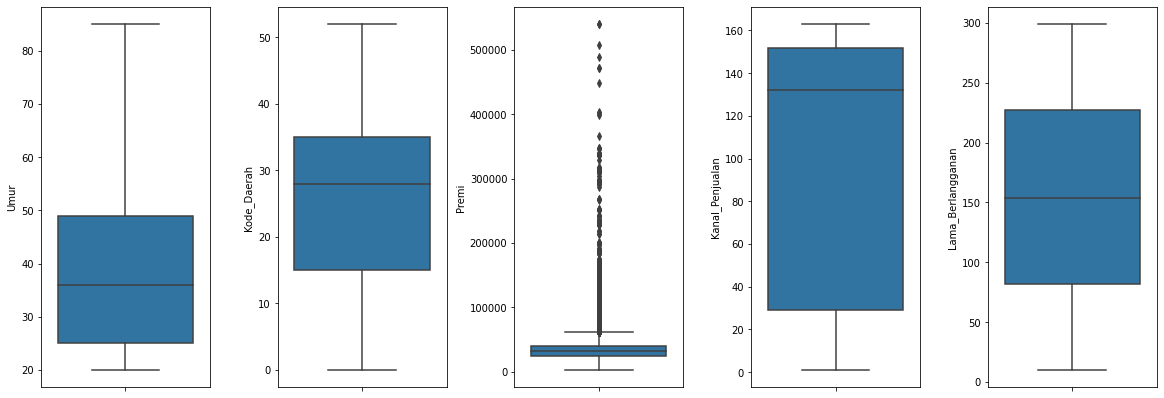

In [ ]:
f, axes = plt.subplots(1, 5, figsize=(20,7), gridspec_kw={'wspace': 0.4,'hspace': 0.4})

sns.boxplot(y=numdf['Umur'], orient='v' , ax=axes[0])
sns.boxplot(y=numdf['Kode_Daerah'], orient='v' , ax=axes[1])
sns.boxplot(y=numdf['Premi'], orient='v' , ax=axes[2])
sns.boxplot(y=numdf['Kanal_Penjualan'],orient='v' , ax=axes[3])
sns.boxplot(y=numdf['Lama_Berlangganan'], orient='v' , ax=axes[4])

#### Melihat deskripsi data

In [ ]:
numdf.describe()

,id,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan
count,285831.000000,271617.000000,271525.000000,271262.000000,271532.000000,271839.000000
mean,142916.000000,38.844336,26.405410,30536.683472,112.021567,154.286302
std,82512.446734,15.522487,13.252714,17155.000770,54.202457,83.694910
min,1.000000,20.000000,0.000000,2630.000000,1.000000,10.000000
25%,71458.500000,25.000000,15.000000,24398.000000,29.000000,82.000000
50%,142916.000000,36.000000,28.000000,31646.000000,132.000000,154.000000
75%,214373.500000,49.000000,35.000000,39377.750000,152.000000,227.000000
max,285831.000000,85.000000,52.000000,540165.000000,163.000000,299.000000


#### Analisis

Pada data yang kita olah, **tidak terdapat outlier**. Walaupun data premi pada boxplot menunjukkan banyak titik-titik di luar plot, namun kita pahami bersama bahwa premi merupakan jumlah premi yang harus dibayarkan per tahun. Tentu saja bisa terjadi banyak data yang distribusinya beda, karena memang bisa saja setiap orang memiliki banyak produk asuransi yang berbeda, bahkan perbedaannya bisa signifikan. Oleh karena itu, bisa dinyatakan bahwa karakteristik data premi itu sendiri di dunia nyata merupakan sesuatu yang bukan anomali/outlier.

## k-Means

In [ ]:
class KMeans:
  def __init__(self, k, cent):
    self.k = k # banyaknya klaster
    #self.use_init_random = use_init_random # penentuan inisialisasi centroid apakah random atau tidak
    self.data = np.array([]) # atribut untuk data yang akan diproses
    self.klaster = {} # dictionary untuk masing-masing klaster
    self.i2d = {} # dictionary untuk convert index data yang sesungguhnya ke data yang diproses
    self.d2i = {} # kebalikan dari i2d
    self.cent = cent # posisi centroid
    self.idx = None # atribut untuk menyimpan index data
    self.sample_silhouette_values = None # shilhoutte coefficient untuk setiap titik
    self.silhouette_avg = None # rata-rata shilhoutte coefficient untuk setiap titik
    self.hist = []

  def run(self):
    # Inisialisasi centroid
    #if self.use_init_random:
      #self.cent = np.array([self.init_centroid(i) for i in range(self.k)])
    #print(self.cent)
    cek = False
    while not cek:
      # hitung jarak setiap titik ke masing-masing centroid
      jarak_cent = np.array([])
      jarak = []
      for c in self.cent:
        # perhitungan menggunakan bantuan library scipy untuk euclidean
        # hal ini dilakukan untuk mendapatkan benefit dari vectorization (supaya lebih cepat)
        jarak.append(cdist(self.data, np.array([c]), 'euclidean').reshape(-1,))
      jarak_cent = np.array(jarak)

      # klaster data ke centroid terdekat
      oldklaster = self.klaster
      self.klaster = self.assign_cluster(jarak_cent)

      # update centroid dengan rata-rata masing-masing klaster
      old = self.cent
      self.update_centroid()

      # cek konvergensi
      cek = self.is_converged(old, self.cent)
      #print(self.cent)
    # hitung jarak setiap titik ke masing-masing centroid
    jarak_cent = np.array([])
    jarak = []
    for c in self.cent:
      # perhitungan menggunakan bantuan library scipy untuk euclidean
      # hal ini dilakukan untuk mendapatkan benefit dari vectorization (supaya lebih cepat)
      jarak.append(cdist(self.data, np.array([c]), 'euclidean').reshape(-1,))
    jarak_cent = np.array(jarak)

    # klaster data ke centroid terdekat
    self.klaster = self.assign_cluster(jarak_cent)

  
  def turn(self, x): 
    return [x[0], x[1]]

  def assign_cluster(self, data):
    # method untuk mengassign data ke klaster masing-masing
    d = np.argmin(data, axis=0)
    res = {}
    for i in range(self.k):
      arr = []
      for j in range(self.data.shape[0]):
        if i == d[j]:
          arr.append(np.array([self.i2d[self.idx[j]][0], self.i2d[self.idx[j]][1]])) 
      res[i] = np.array(arr)
    
    return res

  def setData(self, data, idx):
    # untuk inisialisasi data
    self.idx = idx
    self.data = np.array(data.apply(self.turn, axis=1, result_type='expand'))
    for i in range(self.data.shape[0]):
      self.i2d[self.idx[i]] = (self.data[i][0], self.data[i][1])
    for i in range(self.data.shape[0]):
      self.d2i[(self.data[i][0], self.data[i][1])] = self.idx[i] 

  def init_centroid(self, s):
    # untuk inisialisasi centroid secara random
    set_seed(s)
    return np.random.rand(2)

  def update_centroid(self):
    # mengupdate centroid dengan rata-rata tiap klaster
    for c in range(self.k):
      self.cent[c] = self.klaster[c].mean(axis=0)
  
  def is_converged(self, centroids_old, centroids):
    # jarak antara centroid lama dengan yang baru untuk semua centroid
    distances = [
        cdist([centroids_old[i]], [centroids[i]], 'euclidean').reshape(-1,) for i in range(self.k)
    ]
    # cek apakah tidak ada perubahan jarak/sudah konvergen
    return sum(distances) == 0
  
  def _to_df(self, dfp):
    # digunakan untuk mengconvert hasil klaster ke dataframe
    idx = []
    label = []
    for i in range(self.k):
      for j in self.klaster[i]:
        idx.append(self.d2i[(j[0], j[1])])
        label.append(i)
    left = pd.DataFrame(np.array(idx), columns=['id'])
    dfix = pd.merge(left, dfp, how='inner', on='id')
    dfix['Klaster'] = pd.DataFrame(np.array(label))
    dfix = dfix.drop(['Tertarik'], axis=1)

    return dfix

  def for_visual(self):
    klaster_labeled = []
    label = []
    for i in range(self.k):
      for j in self.klaster[i]:
        klaster_labeled.append(j)
        label.append(i)
    X = np.array(klaster_labeled)
    cluster_labels = np.array(label)

    return X, cluster_labels

  def evaluate(self):
    # kode ini refactor dari dokumentasi scikit-learn
    # untuk evaluasi hasil klaster
    X, cluster_labels = self.for_visual()
    # evaluasi menggunakan shilhoutte coefficient
    # dengan bantuan library scikit-learn
    n_clusters = self.k

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)
    self.sample_silhouette_values = sample_silhouette_values
    self.silhouette_avg = sample_silhouette_values.mean()
    silhouette_avg = self.silhouette_avg

    y_lower = 10
    for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7,
      )

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = self.cent
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
      "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
      % n_clusters,
      fontsize=14,
      fontweight="bold",
    )

    plt.show()

    
  def plot(self):
    # untuk melakukan plot terhadap hasil klaster
    fig, ax = plt.subplots(figsize=(12, 8))
    #for _,v in self.klaster.items():
      #p = pd.DataFrame(v)
      #ax.scatter(p[0], p[1], alpha=.6)
    #for point in self.cent:
      #ax.scatter(point[0], point[1], marker="x", color="black", linewidth=2)
    n_clusters = self.k
    X, cluster_labels = self.for_visual()
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = self.cent
    # Draw white circles at cluster centers
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
      ax.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")

    plt.show()


## Eksperimen I : Drop seluruh Baris yang Memiliki Missing Value

### Drop NaN value

In [ ]:
dfna = numdf.dropna()
id = np.array(dfna['id'])
dfna = dfna.drop(['id'], axis=1)

In [ ]:
dfna.shape

(221199, 5)

In [ ]:
# Simpan hasil dropna ke excel
# dfna.to_excel("data_hasil_dropna.xlsx", index=False)

### Normalisasi Data

In [ ]:
dfna[dfna.columns] = MinMaxScaler().fit_transform(dfna)

In [ ]:
dfna.head()

,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan
0,0.153846,0.634615,0.047251,0.932099,0.301038
1,0.430769,0.750000,0.043104,0.172840,0.512111
2,0.015385,0.884615,0.056002,0.981481,0.377163
3,0.584615,0.923077,0.000000,0.759259,0.183391
4,0.461538,0.673077,0.059953,0.537037,0.636678


In [ ]:
# save data hasil normalisasi
# dfna.to_excel("data_hasil_dropna_norm.xlsx", index=False)

### Reduksi Dimensi dengan PCA

In [ ]:
def pca_and_plot(dfna):
  # data akan direduksi menjadi sebanyak n_components yaitu 2
  pca_2 = PCA(n_components=2)
  pca_2_result = pca_2.fit_transform(dfna)
  data = pd.DataFrame(pca_2_result)
  print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
  # plot hasil reduksi dimensi ke dalam scatter plot
  plt.scatter(data[0], data[1], alpha=.1, color='black')
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')
  plt.show()
  return pca_2_result

Cumulative variance explained by 2 principal components: 69.73%


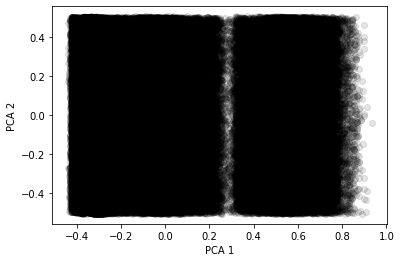

In [ ]:
pca_2_result = pca_and_plot(dfna)

In [ ]:
# save data hasil reduksi
# dfna_pca = pd.DataFrame(pca_2_result)
# dfna_pca.to_excel("data_hasil_dropna_norm_pca.xlsx", index=False)

### Implementasi

In [ ]:
def kmeans_pipeline(pca_2_result, id):
  # hasil dari PCA adalah array, maka diconvert dulu ke dataframe
  sdata = pd.DataFrame(pca_2_result)
  # karena PCA scalingnya ada nilai negatif, maka dinormalisasi menjadi scale 0-1
  sdata[sdata.columns] = MinMaxScaler().fit_transform(sdata)
  # membuat objek KMeans dengan parameter observasi yang ditentukan
  kmeans = KMeans(2, np.array([[0.5, 0.5], [0.99, 0.5]]))
  # set data yang akan diproses
  kmeans.setData(sdata, id)
  # lakukan kmeans clustering untuk data yang sudah diset
  kmeans.run()

  return kmeans

In [ ]:
kmeans = kmeans_pipeline(pca_2_result, id)

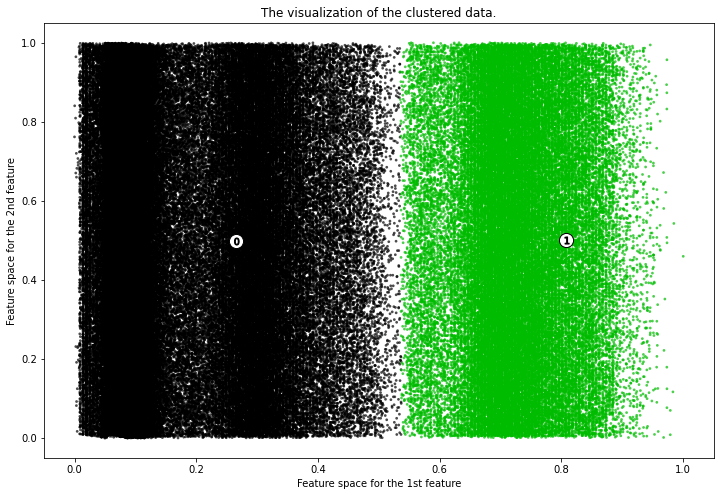

In [ ]:
kmeans.plot()

In [ ]:
kmeans.cent

array([[0.26502203, 0.49914071],
       [0.80676677, 0.50042053]])

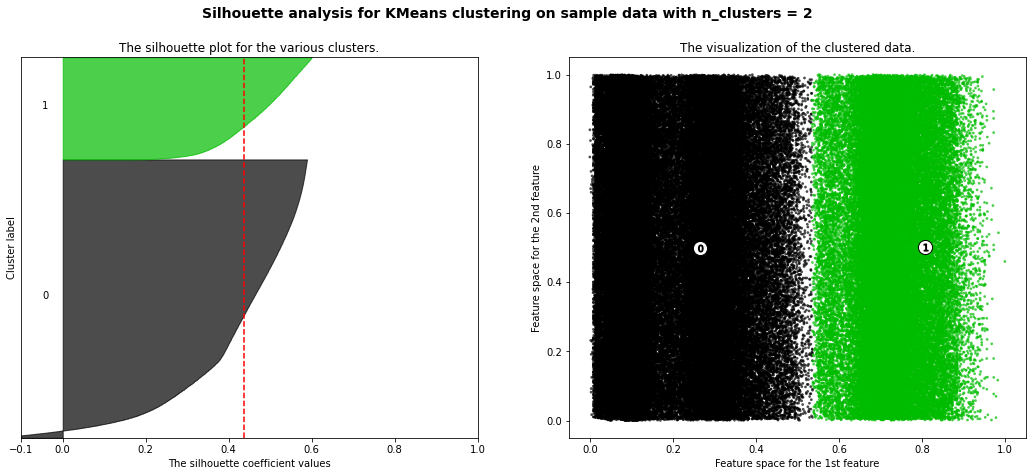

In [ ]:
kmeans.evaluate()

In [ ]:
kmeans.silhouette_avg

0.4361822845384469

In [ ]:
# eks1_sil = pd.DataFrame(kmeans.sample_silhouette_values)
# eks1_sil.to_excel("evaluasi_eksperimen-1.xlsx", index=False, header=False)

In [ ]:
def save_result(kmeans, eks):
  # fungsi untuk menyimpan hasil klasterisasi 
  dt = kmeans._to_df(df)
  dt.sort_values(by=['id'], inplace=True)
  dt.to_excel("hasil-klaster-eksperimen-"+eks+".xlsx",index=False)

In [ ]:
# save_result(kmeans, "I")

## Eksperimen II : Mengisi Missing Value dengan Rerata

Cumulative variance explained by 2 principal components: 69.13%


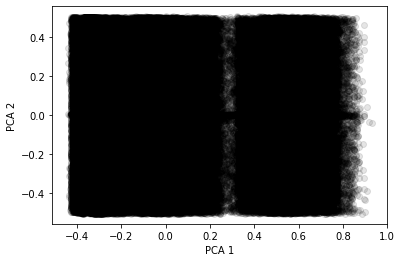

In [ ]:
# copy dataframe yang sudah diambil kolom numeriknya saja
dfm = numdf.copy()

# isi missing value dengan rerata tiap kolomnya
for c in dfm.columns:
  dfm[c].fillna(value=dfm[c].mean(), inplace=True)

# save data haril pengisian rerata
# dfim.to_excel("data_hasil_rerata.xlsx", index=False)

# normalisasi data
dfm[dfm.columns] = MinMaxScaler().fit_transform(dfm)

# save data hasil normalisasi
# dfm.to_excel("data_hasil_rerata_norm.xlsx", index=False)

# drop kolom id, karena tidak akan diproses
dfm.drop(['id'], axis=1, inplace=True)

# reduksi dimensi dengan PCA
pca_2_result_2 = pca_and_plot(dfm)

# save data hasil reduksi
# dfm_pca = pd.DataFrame(pca_2_result_2)
# dfm_pca.to_excel("data_hasil_rerata_norm_pca.xlsx", index=False)

In [ ]:
# generate id untuk setiap baris data, data ini sama dengan data
# data id yang didrop sebelumnya
id_dfm = np.array([i for i in range(1, dfm.shape[0]+1)])

# lakukan kmeans clustering
kmeans_dfm = kmeans_pipeline(pca_2_result_2, id_dfm)

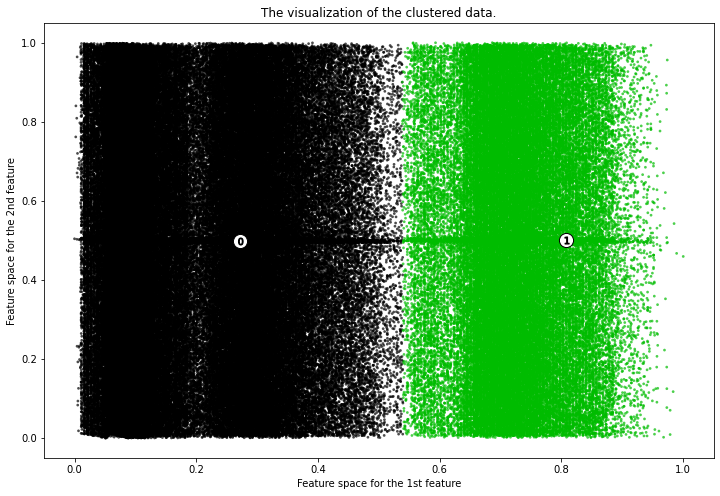

In [ ]:
kmeans_dfm.plot()

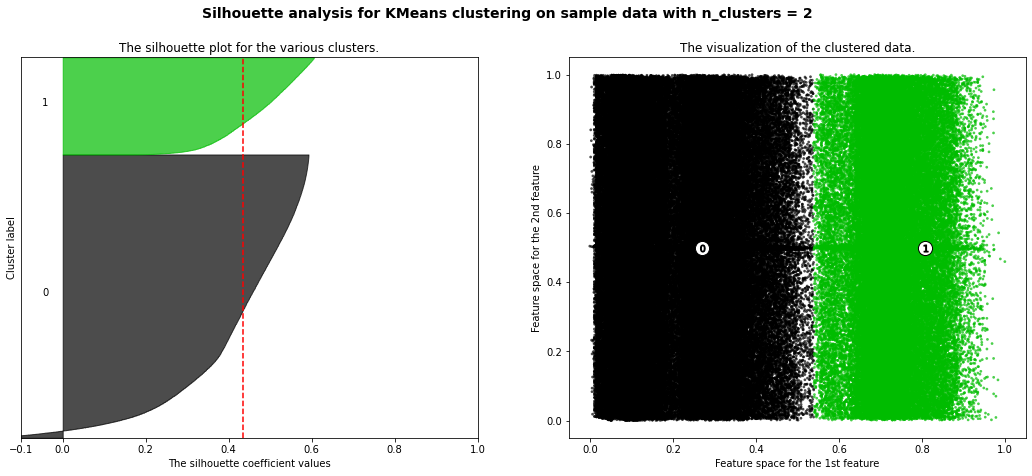

In [ ]:
kmeans_dfm.evaluate()

In [ ]:
kmeans_dfm.cent

array([[0.27119488, 0.49875994],
       [0.80702568, 0.4998344 ]])

In [ ]:
kmeans_dfm.silhouette_avg

0.4343952418495413

In [ ]:
#eks2_sil = pd.DataFrame(kmeans_dfm.sample_silhouette_values)
#eks2_sil.to_excel("evaluasi_eksperimen-2.xlsx", index=False, header=False)

In [ ]:
#save_result(kmeans_dfm, "II")

## Eksperimen III: Mengisi Missing Value dengan KNNImputer

In [ ]:
# copy dataframe yang sudah diambil kolom numeriknya saja
dfk = numdf.copy()

# drop kolom id, karena tidak akan diproses
dfk.drop(['id'], axis=1, inplace=True)

# memastikan tabel kosong berjenis np.nan
dfk.fillna(np.nan, inplace=True)

# normalisasi data
dfk[dfk.columns] = MinMaxScaler().fit_transform(dfk)

# mengubah dataframe ke numpy array
dfka = dfk.to_numpy(na_value=np.nan)

In [ ]:
# Melakukan KNN Imputation
imputer = KNNImputer()
dfka = imputer.fit_transform(dfka)

Cumulative variance explained by 2 principal components: 69.76%


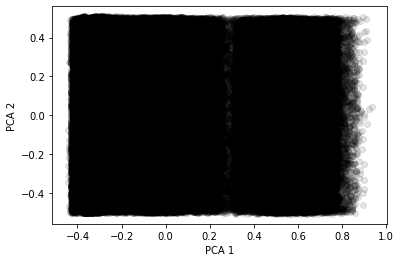

In [ ]:
# Simpan hasil imputation ke dataframe
dfim = pd.DataFrame(dfka, columns=dfk.columns)

# Simpan hasil imputation ke excel
dfim.to_excel("data_hasil_impute.xlsx", index=False)

# reduksi dimensi dengan PCA
pca_2_result_3 = pca_and_plot(dfim)

# save data hasil reduksi
dfim_pca = pd.DataFrame(pca_2_result_3)
dfim_pca.to_excel("data_hasil_impute_norm_pca.xlsx", index=False, header=False)

In [ ]:
# generate id untuk setiap baris data, data ini sama dengan data
# data id yang didrop sebelumnya
id_dfim = np.array([i for i in range(1, dfim.shape[0]+1)])

# lakukan kmeans clustering
kmeans_dfim = kmeans_pipeline(pca_2_result_3, id_dfim)

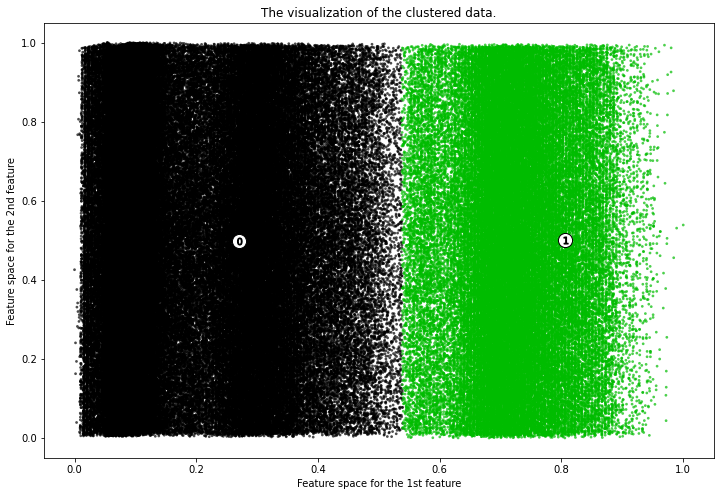

In [ ]:
kmeans_dfim.plot()

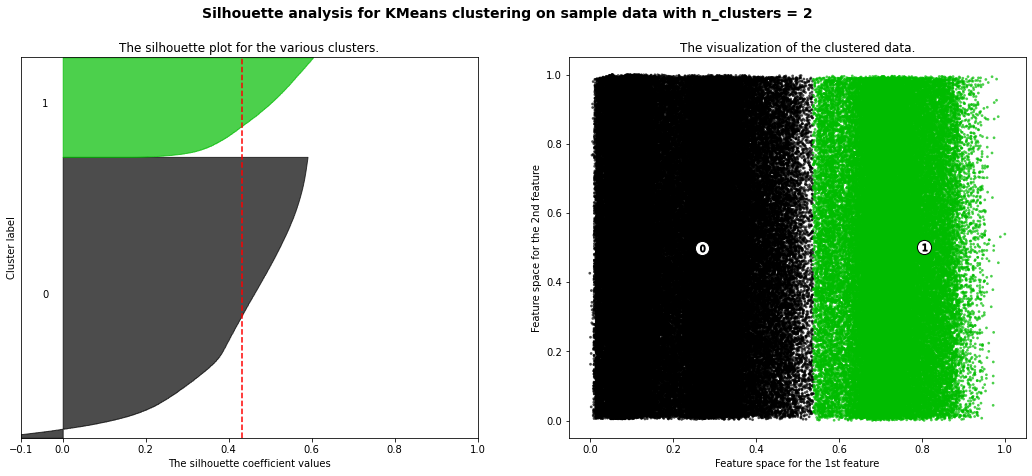

In [ ]:
kmeans_dfim.evaluate()

In [ ]:
kmeans_dfim.cent

array([[0.27044053, 0.49964398],
       [0.80565176, 0.50067356]])

In [ ]:
kmeans_dfim.silhouette_avg

0.4330090848189424

In [ ]:
# eks3_sil = pd.DataFrame(kmeans_dfim.sample_silhouette_values)
# eks3_sil.to_excel("evaluasi_eksperimen-3.xlsx", index=False, header=False)

In [ ]:
# np.sum((eks3_sil < 0).values.ravel())

In [ ]:
#save_result(kmeans_dfim, "III")